In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

dataset_path = os.path.realpath(os.getcwd() + "\\dataset")

Text(0, 0.5, 'Price Value')

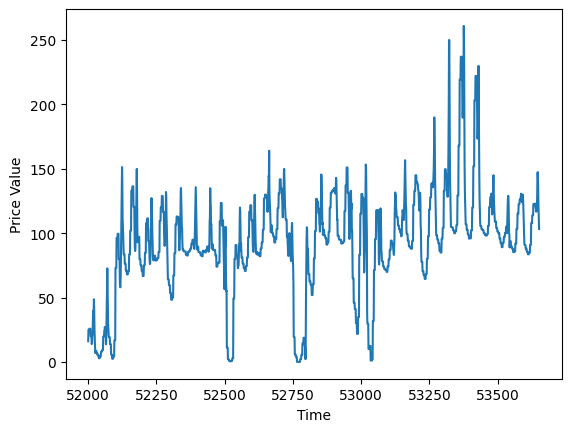

In [31]:
ppr_data = pd.read_csv(dataset_path + '\\power_prices_realized.csv')
ppr_data['delivery_time_utc'] = pd.to_datetime(ppr_data['delivery_time_utc'])
ppr_data.sort_values(by='delivery_time_utc', inplace = True)

#Depuis le début de la guerre d'Ukraine
ppr_data = ppr_data[52000:]

plt.plot(ppr_data.index, ppr_data["da_price"], label = 'da_price')
plt.xlabel("Time")
plt.ylabel("Price Value")

Baseline

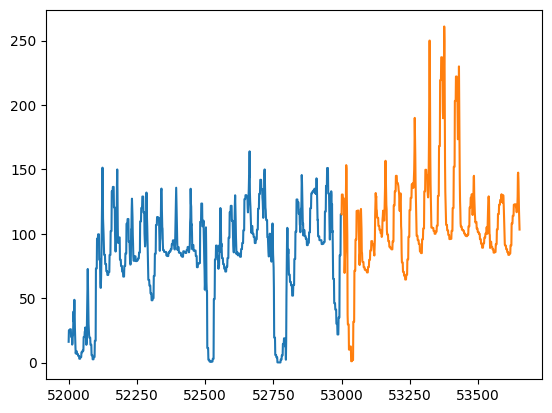

In [32]:
time = ppr_data.index
series = ppr_data['da_price'].to_numpy()

# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.plot(time_train, x_train)
plt.plot(time_valid, x_valid)

# RNN Recuurent Neural Network

In [33]:
# Parameters
window_size = 100
batch_size = 128
shuffle_buffer_size = 1000

In [34]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1])) # Tuple of Features and Labels

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer) #Shuffle so there's no sequence bias
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1) #prefetch() -> tensorflow will prepare in advance the next batch
    
    return dataset

# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [59]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
"""
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

mse = 299.01
mae = 9.8
"""
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 64)           256       
                                                                 
 lstm (LSTM)                 (None, 100, 64)           33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [60]:
###FINDING THE BEST LEARNING RATE

# Get initial weights
init_weights = model.get_weights()

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer)

# Train the model
history = model.fit(dataset, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 7s 189ms/step - loss: 58.2601 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 2s 185ms/step - loss: 57.7544 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 2s 179ms/step - loss: 56.9444 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 2s 219ms/step - loss: 55.9169 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 2s 198ms/step - loss: 54.7636 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 2s 178ms/step - loss: 53.5120 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 2s 248ms/step - loss: 52.1548 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 3s 282ms/step - loss: 50.6764 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 2s 198ms/step - loss: 49.0912 - lr: 2.5119e-08
Epoch 10/100
8/8 [==============================] - 2s 247ms/step - loss: 47.3511 - lr: 2.8184e-08
Epoch 11/100
8/8 [=

(1e-08, 0.001, 0.0, 50.0)

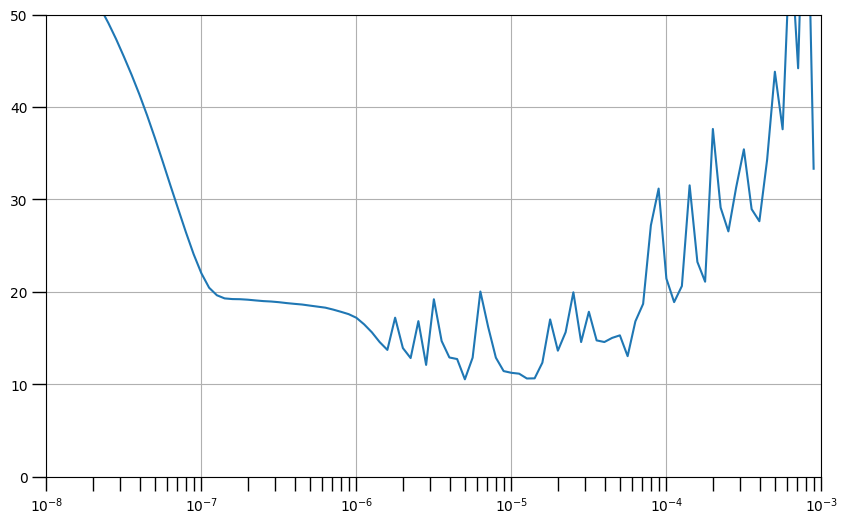

In [61]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

In [62]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])

# Train the model
history = model.fit(dataset,epochs = 500)

Epoch 1/500
8/8 [==============================] - 8s 216ms/step - loss: 50.7452 - mae: 51.2448
Epoch 2/500
8/8 [==============================] - 2s 248ms/step - loss: 24.2600 - mae: 24.7533
Epoch 3/500
8/8 [==============================] - 2s 243ms/step - loss: 22.2170 - mae: 22.7135
Epoch 4/500
8/8 [==============================] - 3s 286ms/step - loss: 22.2069 - mae: 22.7040
Epoch 5/500
8/8 [==============================] - 2s 190ms/step - loss: 19.7606 - mae: 20.2563
Epoch 6/500
8/8 [==============================] - 2s 175ms/step - loss: 19.7342 - mae: 20.2272
Epoch 7/500
8/8 [==============================] - 2s 189ms/step - loss: 18.9817 - mae: 19.4753
Epoch 8/500
8/8 [==============================] - 2s 181ms/step - loss: 18.8165 - mae: 19.3121
Epoch 9/500
8/8 [==============================] - 2s 203ms/step - loss: 18.5391 - mae: 19.0354
Epoch 10/500
8/8 [==============================] - 2s 191ms/step - loss: 18.1185 - mae: 18.6096
Epoch 11/500
8/8 [=====================

In [63]:
# Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(loss)) 

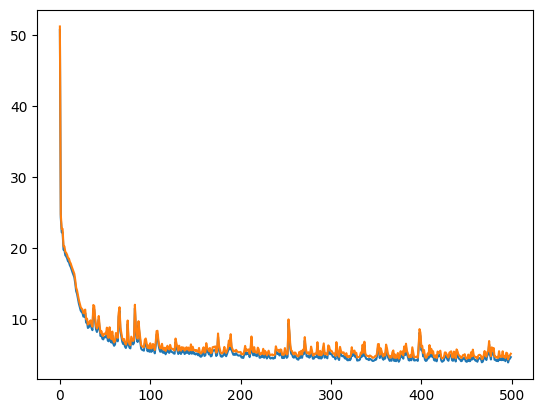

In [64]:
plt.plot(epochs, loss)
plt.plot(epochs, mae)

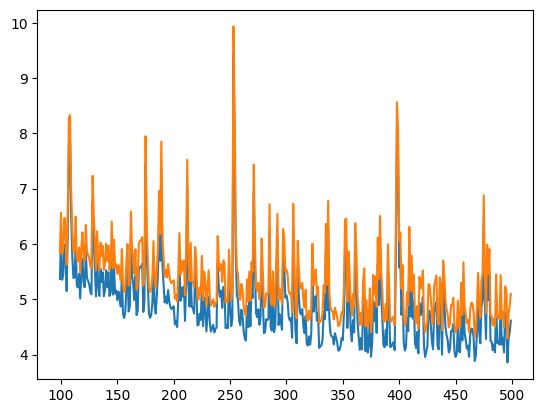

In [65]:
# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

plt.plot(epochs_zoom, loss_zoom)
plt.plot(epochs_zoom, mae_zoom)

In [66]:
#PREDICTION

def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze()

6/6 [==============================] - 3s 105ms/step


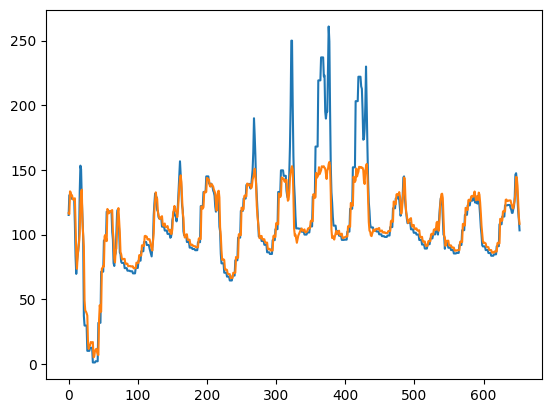

In [67]:
plt.plot(x_valid)
plt.plot(results)

In [68]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

333.6944
8.836306
